<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Problem 5: DCGAN, WGAN, WGAN-GP

## Download Data

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz

--2024-10-15 05:29:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.134.115, 52.219.169.12, 3.5.134.245, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.134.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  4.79MB/s    in 13s     

2024-10-15 05:29:36 (1.91 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-15 05:29:36--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.170.192, 3.5.135

## Library Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [3]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: Tesla T4
GPU Count: 1
GPU Memory Allocated: 0
GPU Memory Cached: 0


## Load Data

### Define FashionMNIST

In [4]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = (np.copy(imgs) / 255).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = label.to(self.device)
            return img, label
        else:
            return img

    def stratified_indices(self, num_labels, removed_indicies=[]):
        """
        Create a stratified subset of the dataset using num_labels data points
        """
        # Get remaining indices after removing removed_indicies
        remaining_indices = np.setdiff1d(np.arange(len(self)), removed_indicies)

        indices = []
        for cls in range(10):
            cls_indices = remaining_indices[self.labels[remaining_indices] == cls]
            num_to_select = min(len(cls_indices), num_labels // 10)
            selected_indices = np.random.choice(cls_indices, num_to_select, replace=False)
            indices.extend(selected_indices.tolist())
        return indices

    def create_subsets(self, num_labels):
        """Create labeled and unlabeled subsets with no overlapping indices."""
        assert num_labels <= len(self), "Number of labels must be less than or equal to the dataset size"

        labeled_indices = self.stratified_indices(num_labels)

        all_indices = set(range(len(self)))
        remaining_indices = list(all_indices - set(labeled_indices))

        remaining_dataset = self.labels[remaining_indices]
        unlabeled_indices = self.stratified_indices(num_labels, labeled_indices)

        labeled_subset = torch.utils.data.Subset(self, labeled_indices)
        unlabeled_subset = torch.utils.data.Subset(self, unlabeled_indices)

        return labeled_subset, unlabeled_subset

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset('/content', 'train', device=device)
test = FasionMNISTDataset('/content', 'test', device=device)

traindataloader = DataLoader(train, batch_size=64, shuffle=True, generator=gen)
testdataloader = DataLoader(test, batch_size=64, shuffle=True, generator=gen)

## Model Building

### GAN Modules

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels, filters):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(channels, filters, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filters, filters * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filters * 2, filters * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filters * 4, filters * 8, kernel_size=3, stride=2, padding=0, bias=False),  # Adjusted Layer
            nn.BatchNorm2d(filters * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filters * 8, 1, kernel_size=1, stride=1, padding=0, bias=False),  # Adjusted Layer
            nn.Sigmoid()
        )
        self.apply(self.weights_init)

    def forward(self, x):
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, z_dim, channels, filters):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(z_dim, filters * 8, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(filters * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters * 8, filters * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(filters * 4, filters, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(filters),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters * 4, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            )
        self.apply(self.weights_init)

    def forward(self, x):
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

### DCGAN

In [8]:
class DCGAN:
    def __init__(self, z_dim, channels, filters, device):
        self.z_dim = z_dim
        self.channels = channels
        self.filters = filters
        self.discriminator = Discriminator(channels, filters).to(device)
        self.adam_discrim = optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999)) #, betas=(0.5, 0.999)
        self.generator = Generator(z_dim, channels, filters).to(device)
        self.adam_gen = optim.Adam(self.generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()
        self.device = device
        self.img_list = []
        self.evaluation_noise = torch.randn(64, self.z_dim, 1, 1, device=self.device)

    def train_discriminator(self, real_imgs, real_labels, fake_labels, batch_size):
        self.discriminator.zero_grad()

        # Train on reals
        output = self.discriminator(real_imgs).view(-1)
        real_loss = self.loss(output, real_labels.squeeze(1))
        real_loss.backward()
        avg_real = output.mean().item()

        # train on fakes
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise)
        output = self.discriminator(fake_imgs.detach()).view(-1)
        fake_loss = self.loss(output, fake_labels.squeeze(1))
        fake_loss.backward()
        avg_fake = output.mean().item()
        discrim_loss = real_loss + fake_loss
        self.adam_discrim.step()

        return fake_imgs, discrim_loss, avg_real, avg_fake



    def train_generator(self, fake_imgs, real_labels):
        self.generator.zero_grad()
        output = self.discriminator(fake_imgs).view(-1)
        real_loss = self.loss(output, real_labels.squeeze(1))
        real_loss.backward()
        self.adam_gen.step()

        return real_loss, output.mean().item()

    def train_one_epoch(self, train_loader, batch_size):
        for i, (real_imgs, _) in enumerate(train_loader):
            current_batch_size = real_imgs.size(0)

            fake_lables = torch.zeros(current_batch_size, 1, device=self.device)
            real_labels = torch.ones(current_batch_size, 1, device=self.device)

            fake_imgs, discrim_loss, avg_real, avg_fake1 = self.train_discriminator(real_imgs, real_labels, fake_lables, current_batch_size)
            gen_loss, avg_fake2 = self.train_generator(fake_imgs, real_labels)

            if i % 100 == 0:
                print(f'[{i}/{len(train_loader)}] DLoss: {discrim_loss.item():.4f} GLoss: {gen_loss.item(): .4f}, D(x): {avg_real:.4f} D(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}')

            #wandb goes here for g and d losses
            # with torch.no_grad():
            #     fake = self.generator(self.evaluation_noise).detach().cpu()
            # self.img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

    def train(self, traindataloader, epochs, batch_size, noise):
        print('----------- VAE Train Start! ------------')
        for epoch in range(epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(traindataloader, batch_size)

    def generate_images(self, num_images):
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=dc.device)
            generated_images = self.generator(noise)
            generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')


In [9]:
dc = DCGAN(100, 1, 64, device)
dc.train(traindataloader, 10, 64, 100)

----------- VAE Train Start! ------------
----------- Epoch #1 ------------
[0/938] DLoss: 1.4031 GLoss:  0.7772, D(x): 0.4743 D(G(z)): 0.4736/0.4615
[100/938] DLoss: 1.1311 GLoss:  0.8458, D(x): 0.5844 D(G(z)): 0.4435/0.4304
[200/938] DLoss: 1.0246 GLoss:  0.9932, D(x): 0.5920 D(G(z)): 0.3850/0.3749
[300/938] DLoss: 0.9710 GLoss:  1.0425, D(x): 0.6147 D(G(z)): 0.3743/0.3577
[400/938] DLoss: 0.9054 GLoss:  1.1416, D(x): 0.6607 D(G(z)): 0.3731/0.3287
[500/938] DLoss: 0.8152 GLoss:  1.2568, D(x): 0.6507 D(G(z)): 0.3006/0.2921
[600/938] DLoss: 0.8892 GLoss:  1.2330, D(x): 0.6801 D(G(z)): 0.3708/0.3135
[700/938] DLoss: 0.7507 GLoss:  1.4288, D(x): 0.7052 D(G(z)): 0.3070/0.2583
[800/938] DLoss: 0.7650 GLoss:  1.3046, D(x): 0.6512 D(G(z)): 0.2699/0.2926
[900/938] DLoss: 0.6929 GLoss:  1.4405, D(x): 0.7230 D(G(z)): 0.2985/0.2442
----------- Epoch #2 ------------
[0/938] DLoss: 0.7802 GLoss:  1.4959, D(x): 0.7241 D(G(z)): 0.3369/0.2535
[100/938] DLoss: 0.7850 GLoss:  1.2865, D(x): 0.6157 D(G(z

In [11]:
dc.generator.eval()

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [12]:
# Number of images you want to generate
num_images = 16

# Sample random noise


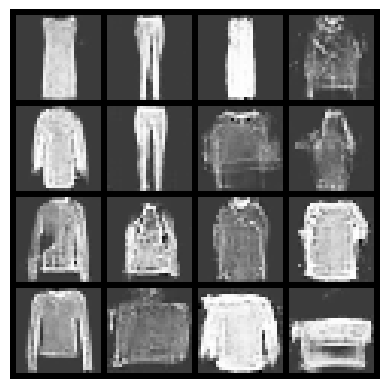

In [15]:
with torch.no_grad():  # Disable gradient calculation
    noise = torch.randn(num_images, dc.z_dim, 1, 1, device=dc.device)
    generated_images = dc.generator(noise)
    generated_images = (generated_images + 1) / 2
    grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
    np_grid = grid.permute(1, 2, 0).numpy()
    plt.imshow(np_grid)
    plt.axis('off')